In [87]:

import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

#### Import your dataset

Disini coba ganti setiap path sesuai path yang benernya di local kalian / di drive gimana

In [88]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf

#Change every path to your dataset train, and test path

source_path_train = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_dikit/train'
source_path_test = '/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_dikit/test'


### Prepare Pre-trained model
Download the inception model for pre-trained

### Generate data
Using ImageGenerator from Keras.
This function include augmentation to optimize training data image

In [89]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

def train_val_generators(train_folder, test_folder):
    """
    TRAIN VAL GENERATORS
    """
    # Set the image
    img_size = (150, 150)

    # Instantiate the ImageDataGenerator class
    # augmenting the images
    train_datagen = ImageDataGenerator(
        rescale=1./255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255.)

    # Load training images and labels
    train_generator = train_datagen.flow_from_directory(
        train_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    # Load testing images and labels
    validation_generator = validation_datagen.flow_from_directory(
        test_folder,
        target_size=img_size,
        batch_size=32,
        class_mode='categorical'
    )

    #INI BUAT NGECEK IMAGE YANG GABISA DIBUKA
    # NAnti dia akan ngasi tau nama file image yang ga sesuai format or corrupt data
    for file_path in train_generator.filepaths + validation_generator.filepaths:
        try:
            img = Image.open(file_path)
        except (OSError, Image.UnidentifiedImageError):
            print(f"UnidentifiedImageError: cannot identify image file: {file_path}")

    return train_generator, validation_generator

In [90]:
train_generator, validation_generator = train_val_generators(source_path_train, source_path_test)

Found 11815 images belonging to 15 classes.
Found 1198 images belonging to 15 classes.


In [91]:
# Get a batch of data from the generators
train_images, train_labels = next(train_generator)
validation_images, validation_labels = next(validation_generator)

print(f"Images of training generator have shape: {train_images.shape}")
print(f"Labels of training generator have shape: {train_labels.shape}")
print(f"Images of validation generator have shape: {validation_images.shape}")
print(f"Labels of validation generator have shape: {validation_labels.shape}")

Images of training generator have shape: (32, 150, 150, 3)
Labels of training generator have shape: (32, 15)
Images of validation generator have shape: (32, 150, 150, 3)
Labels of validation generator have shape: (32, 15)


In [92]:
num_validation_samples = len(validation_generator.labels)
print(f"Total number of labels in the validation set: {num_validation_samples}")

Total number of labels in the validation set: 1198


#### Prepare the Inception 3

In [93]:

# Import the InceptionResNetV2 model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Create an instance of the InceptionResNetV2 model from the local pre-trained weights
local_weights_file = '/tmp/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [94]:
def create_pre_trained_model():
  """
  InceptionResNetV2
  """

  pre_trained_model = tf.keras.applications.InceptionResNetV2(
                                  include_top=False,
                                  weights="imagenet",
                                  input_tensor=None,
                                  input_shape=(150, 150, 3),
                                  pooling=None,
                                  classes=1000,
                                  classifier_activation="softmax",
                                  
                              )

  



  return pre_trained_model

In [95]:
# Pre-trained model summmary

pre_trained_model = create_pre_trained_model()
pre_trained_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1015 (Conv2D)           (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_1015 (Batc  (None, 74, 74, 32)  96          ['conv2d_1015[0][0]']            
 hNormalization)                                                                                  
                                                                                

In [96]:

total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 54,336,736 total parameters in this model.
There are 54,276,192 trainable parameters in this model.


In [97]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


###### FINAL MODEL

Cek classnya ada berapa

In [98]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout



def create_final_model(pre_trained_model):
    pre_trained_model.trainable = False

    # Create the model
    model = Sequential()
    model.add(pre_trained_model)

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))

    model.add(Dense(15, activation='softmax'))

    model.compile(optimizer = tf.optimizers.Adam(),
                loss = 'categorical_crossentropy',
                metrics=['accuracy'])

    return model

In [99]:

# Save your model in a variable
model = create_final_model(pre_trained_model)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 61,550,319 total parameters in this model.
There are 7,213,583 trainable parameters in this model.


In [100]:
# TRAINING FIT
# epoch adjust sesuai kebutuhan
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator)

Epoch 1/20
370/370 [==============================] - 235s 627ms/step - loss: 2.3747 - accuracy: 0.3792 - val_loss: 1.3542 - val_accuracy: 0.5476
Epoch 2/20
370/370 [==============================] - 240s 648ms/step - loss: 1.6499 - accuracy: 0.4457 - val_loss: 1.3430 - val_accuracy: 0.5334
Epoch 3/20
370/370 [==============================] - 236s 637ms/step - loss: 1.5549 - accuracy: 0.4801 - val_loss: 1.3036 - val_accuracy: 0.5826
Epoch 4/20
370/370 [==============================] - 236s 637ms/step - loss: 1.5127 - accuracy: 0.4980 - val_loss: 1.2540 - val_accuracy: 0.5960
Epoch 5/20
370/370 [==============================] - 247s 667ms/step - loss: 1.4803 - accuracy: 0.5067 - val_loss: 1.2155 - val_accuracy: 0.6294
Epoch 6/20
370/370 [==============================] - 247s 668ms/step - loss: 1.4731 - accuracy: 0.5068 - val_loss: 1.1783 - val_accuracy: 0.6252
Epoch 7/20
370/370 [==============================] - 238s 643ms/step - loss: 1.4325 - accuracy: 0.5202 - val_loss: 1.2755 -

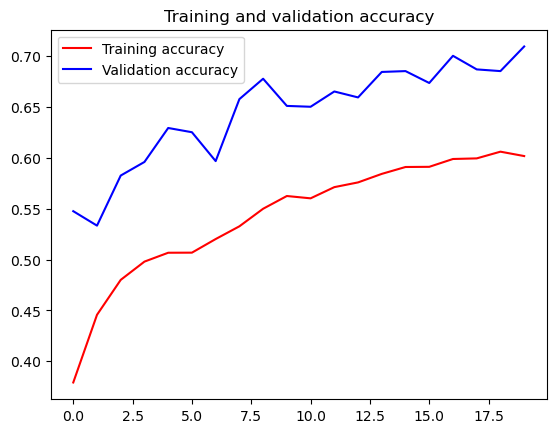

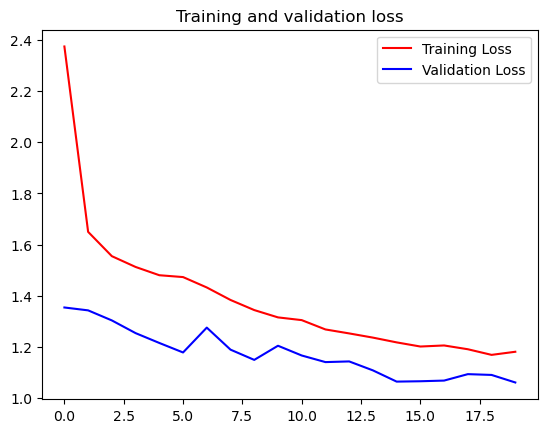

In [101]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()


In [102]:
# Get the class labels and their corresponding indices
class_labels = train_generator.class_indices

# Reverse the dictionary to get the label-to-index mapping
label_to_index = {v: k for k, v in class_labels.items()}

class_names = []

# Print the labels
print("Class Labels:")
for label, index in label_to_index.items():
    print(f"Index: {index}, Label: {label}")
    class_names.append(index)

Class Labels:
Index: Aglaonema, Label: 0
Index: Apple, Label: 1
Index: Aster, Label: 2
Index: Daisy, Label: 3
Index: Grape, Label: 4
Index: Iris, Label: 5
Index: Jasmine, Label: 6
Index: Lavender, Label: 7
Index: Marigold, Label: 8
Index: Orchid, Label: 9
Index: Poppy, Label: 10
Index: Potato, Label: 11
Index: Rose, Label: 12
Index: Soybean, Label: 13
Index: sunflower, Label: 14


In [103]:

# Load the image you want to predict
image_path = "/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/dataset_many/rose.jpeg"
image = Image.open(image_path)
image = image.resize((150, 150))  # Resize the image to match the input size of the model

# Preprocess the image
image_array = np.array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

# Make the prediction
prediction = model.predict(image_array)
predicted_class_index = np.argmax(prediction)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicted class: Rose


In [104]:
model.save("/Users/arsyaninsa/Documents/Data_Personal/Kuliah/Bangkid/Nyobas Modelling/model/Resnet50_150_(15_dataset).h5")